In [137]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, cross_val_score,train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor

In [138]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [139]:
X = df.drop(columns= 'Potability')
y = df['Potability']

In [140]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [141]:
# Select the columns with missing values
columns_with_missing = ['ph', 'Sulfate', "Trihalomethanes"]

# Create a copy of the DataFrame
impute_X = X_scaled.copy()

# Perform KNN imputation with the optimal K value
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_data = imputer.fit_transform(impute_X[columns_with_missing])

# Update the original DataFrame with the imputed values
X_scaled[columns_with_missing] = imputed_data

In [142]:

X_train, X_test, y_train, y_test = train_test_split(imputed_data, y, test_size = 0.2, random_state = 45)
X_train.shape

(2620, 3)

In [143]:
model = RandomForestClassifier(random_state=45)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=45)

**Baseline Model**

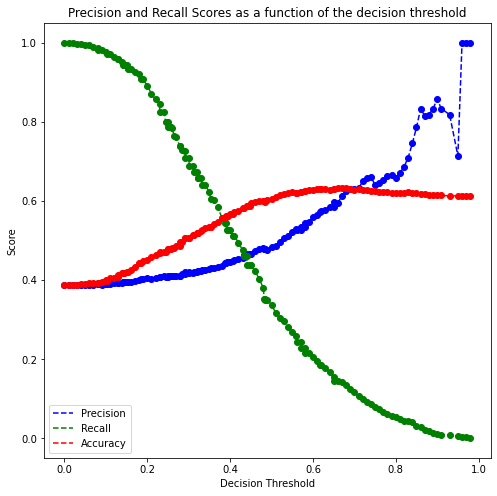

In [144]:
cross_val_ypred=cross_val_predict(RandomForestClassifier(random_state=1), X_train,
                                 y_train, cv=5, method='predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:, 1])
acc=np.ndarray(shape=(len(thresholds),))
i=0
for th in thresholds:
    y_pred = cross_val_ypred[:, 1]>th
    y_pred=y_pred.astype(int)
    acc[i]=accuracy_score(y_pred, y_train)
    i = i+1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.plot(thresholds, acc, "r--", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color='blue')
    plt.plot(thresholds, recalls[:-1], "o", color='green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc="best")
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  99.73282442748092
ROC-AUC:  0.9995045485873504
Precision:  1.0
Recall:  0.9931237721021611


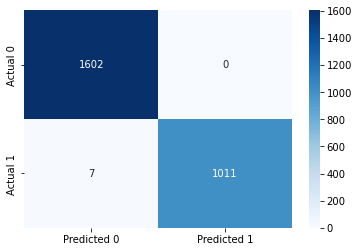

In [145]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.6

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  57.62195121951219
ROC-AUC:  0.5661276223776225
Precision:  0.44886363636363635
Recall:  0.3038461538461538


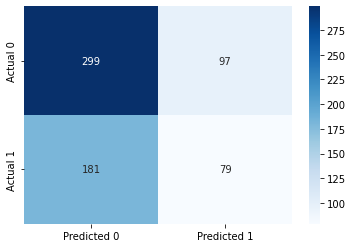

In [146]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

**Tuning the Model**

In [147]:
#Optimizing with OOB score takes half the time as compared to cross validation. 
#The number of models developed with OOB score tuning is one-fifth of the number of models developed with
#5-fold cross validation
import itertools as it


n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_samples

2620

In [148]:
n_features

3

In [149]:
print(model.max_depth)

None


In [150]:
print(model.max_leaf_nodes)

None


In [151]:
params = {'n_estimators': [50],
          'max_depth': range(4, 29, 2), #what were these changed to, just deleted
          'max_leaf_nodes': range(10, 33), #this was changed, forget
        'max_features': range(1, 3),
         'sub_samples':[0.5]}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_precision = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],
                                  max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_pred = (model.oob_decision_function_[:,1]>=0.5).astype(int)     
    oob_precision[i] = precision_score(y_train, oob_pred)
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_precision)])
print("Best score (R-squared) = ", np.max(oob_precision))

Best params =  (50, 8, 10, 1, 0.5)
Best score (R-squared) =  0.6636771300448431


In [152]:
model = RandomForestClassifier(random_state=1, max_features=1, n_estimators = 50, 
                               oob_score=True, max_depth =8, max_leaf_nodes = 10).fit(X_train, y_train)

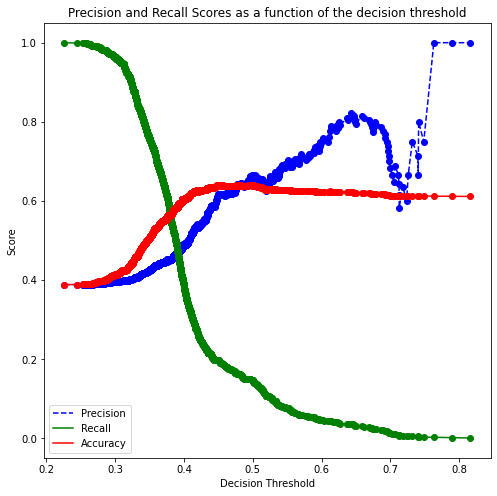

In [153]:
y_pred_prob = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [154]:
# Thresholds with precision and recall
con = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1), acc.reshape(-1,1)], axis = 1)

In [155]:
con[(con[:,2]>0.47),:]

array([[0.22616671, 0.38869798, 1.        , 0.38854962],
       [0.24377598, 0.38846448, 0.99901768, 0.3889313 ],
       [0.25353079, 0.38861292, 0.99901768, 0.38931298],
       ...,
       [0.39064132, 0.46738072, 0.47151277, 0.58625954],
       [0.3906546 , 0.46783626, 0.47151277, 0.58587786],
       [0.39068984, 0.46731707, 0.47053045, 0.58549618]])

Accuracy:  65.99236641221374
ROC-AUC:  0.6885839532607816
Precision:  0.7212543554006968
Recall:  0.20333988212180745


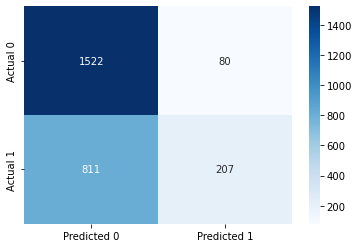

In [156]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.47

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  61.737804878048784
ROC-AUC:  0.5847707847707847
Precision:  0.5616438356164384
Recall:  0.1576923076923077


<AxesSubplot:>

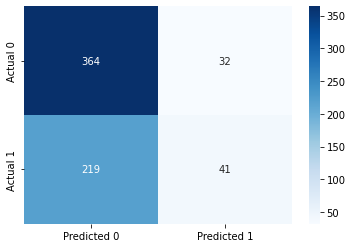

In [157]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.47

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [158]:
pd.concat([pd.Series(model.feature_importances_), pd.Series(X_train.columns)],axis=1).sort_values(by = 0,ascending = False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'